<a href="https://colab.research.google.com/github/ItsCosmas/Traffic-Sign-Classification/blob/master/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Clone* the *repository* containing the dataset into colab. This will allow access to the dataset inside this colab environment.

In [31]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [32]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


The dataset is listed above: A *spreadsheet signnames.csv* and then *pickle files containing the train, test and validate* datasets.

Importing the Relevant Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [0]:
np.random.seed(0)

*Unpickle* the Data to make it usable.

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
  
  
X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

We analyze the dataset to see how it looks like.

In [36]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


*shape* gives us the number of *images*, *dimensions in pixels* and* depth*.
The Images have a depth of 3 because they're in **RGB** format and thus the depth 3 for each color channel.

Next We Assert The dataset to see if its correct

In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

Showing the training set.
If the code seems cryptic you can check out the [pandas iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) documentation to see how it's used to allow you to iterate over DataFrame rows as (index, Series) pairs.  

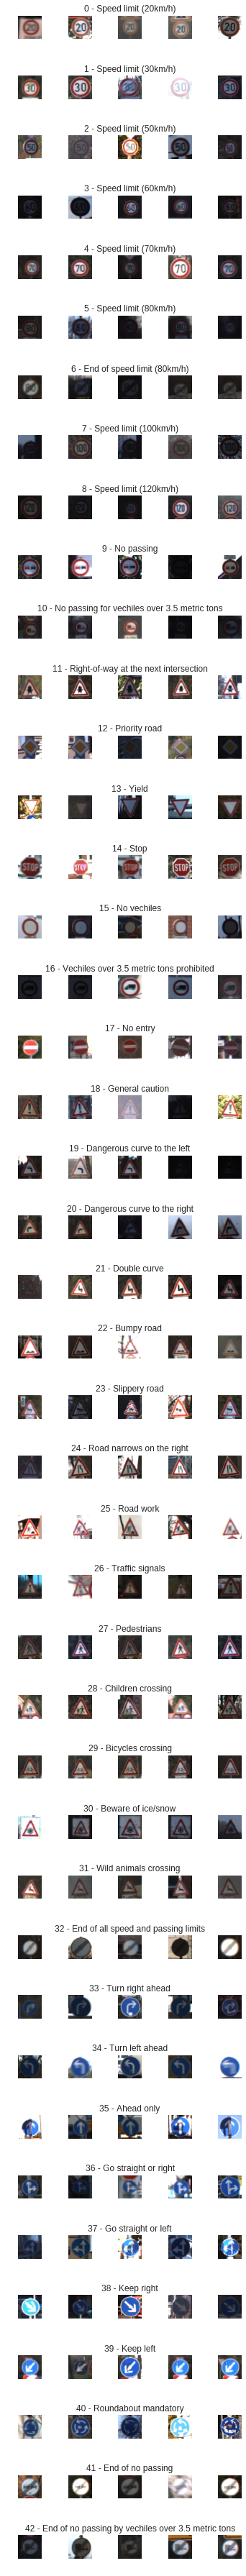

In [38]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

plotting the distribution of the dataset.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


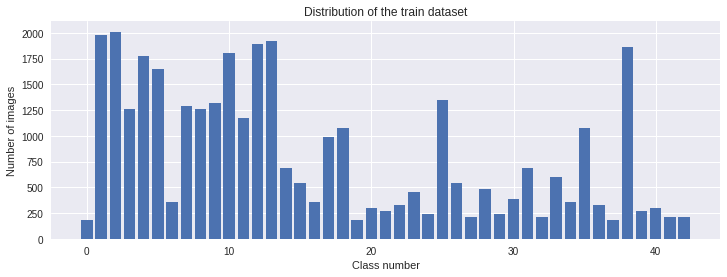

In [39]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
1


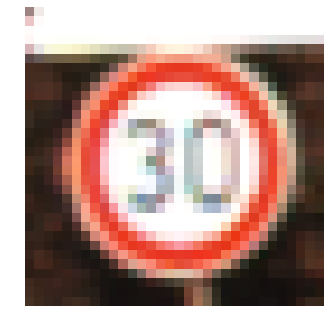

In [40]:
plt.imshow(X_train[3000])
plt.axis("off")
print(X_train[3000].shape)
print(y_train[3000])

Now We'll Convert the image to grayscale i.e binary images with only two colors black or white.
**Why Convert to grayscale?** , Well for traffic signs *is color really important*? I don't think so, the important details are the **edges** and the **shapes** of the signs. Also We'll now need **fewer input parameters** for our neural network. Plus **less Computing Power**.

(32, 32)


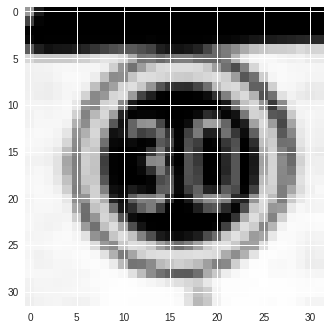

In [41]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[3000])
plt.imshow(img)
#plt.axis("off")
print(img.shape)

Next We apply the Histogram Equalization technique to standardize lighting in all our images. Well because some images are more brighter and others very dim. Thus We need to give them a similar lighting effect. You can read about [Histogram Equalization Here](https://en.wikipedia.org/wiki/Histogram_equalization)

(32, 32)


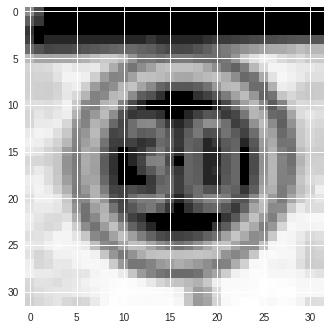

In [42]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
print(img.shape)

Next We apply Preprocessing to all our images.

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalize the images, i.e. convert the pixel values to fit btwn 0 and 1
  img = img/255
  return img

Map Function Iterates through an entire array and perfoms a given operation. You can read about it  [here](https://www.journaldev.com/22960/python-map-function). So here we Preprocess all the images and update their variable storage.

In [0]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

We Plot a random image from our train data to see that its correctly preprocessed

(34799, 32, 32)


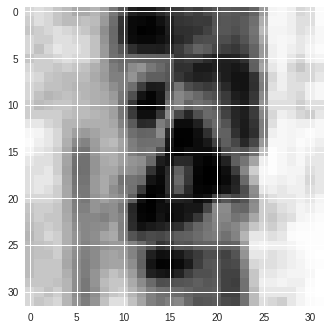

In [45]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

Next We add a depth to our images, that is required for our Convolutional Layer

In [46]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


Next One Hot Encode the data labels. Here's an article that explains what is [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Also refer to the Keras to_categorical documentation [here](https://keras.io/utils/)

In [0]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

Next, It's time to define a leNet model. You may want to read about the LeNet model [here](https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086)

In [0]:
def leNet_model():
  model = Sequential()
  # add the convolutional layer
  #filters, size of filters,input_shape,activation_function
  model.add(Conv2D(30,(5,5), input_shape= (32,32,1), activation = 'relu'))
  #pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  # add another convolutional layer
  model.add(Conv2D(15, (3, 3) , activation = 'relu'))
  # pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  #Flatten the image to 1 dimensional array
  model.add(Flatten())
  #add a dense layer : amount of nodes, activation
  model.add(Dense(500, activation = 'relu'))
  # place a dropout layer
  #0.5 drop out rate is recommended, half input nodes will be dropped at each update
  model.add(Dropout(0.5))
  # defining the ouput layer of our network
  model.add(Dense(num_classes, activation = 'softmax'))
  
  
  #Compile Model
  # we use Adam optimizer with a learning rate 0f 0.01
  # A categorical_crossentropy'
  
  model.compile(Adam(lr = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return model

In [49]:
model = leNet_model()
#print a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               270500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
__________

Now to training and evaluating the model

In [50]:
# define our training paramters
history = model.fit(X_train, y_train , epochs = 15, validation_data = (X_val, y_val), verbose = 1, shuffle = 1, )

Train on 34799 samples, validate on 4410 samples
Epoch 1/15
34799/34799 [==============================] - 10s 298us/step - loss: 1.4591 - acc: 0.5651 - val_loss: 0.7968 - val_acc: 0.7512
Epoch 2/15
34799/34799 [==============================] - 10s 287us/step - loss: 0.9110 - acc: 0.7125 - val_loss: 0.7708 - val_acc: 0.7649
Epoch 3/15
34799/34799 [==============================] - 10s 288us/step - loss: 0.8272 - acc: 0.7395 - val_loss: 0.8540 - val_acc: 0.7519
Epoch 4/15
34799/34799 [==============================] - 10s 286us/step - loss: 0.7672 - acc: 0.7563 - val_loss: 0.7201 - val_acc: 0.7916
Epoch 5/15
34799/34799 [==============================] - 10s 288us/step - loss: 0.7609 - acc: 0.7587 - val_loss: 0.7081 - val_acc: 0.7884
Epoch 6/15
34799/34799 [==============================] - 10s 287us/step - loss: 0.7511 - acc: 0.7623 - val_loss: 0.6435 - val_acc: 0.8113
Epoch 7/15
34799/34799 [==============================] - 10s 286us/step - loss: 0.7149 - acc: 0.7728 - val_loss: 0.7

Plotting and Visualizing how the network perfomed

Text(0.5, 0, 'epoch')

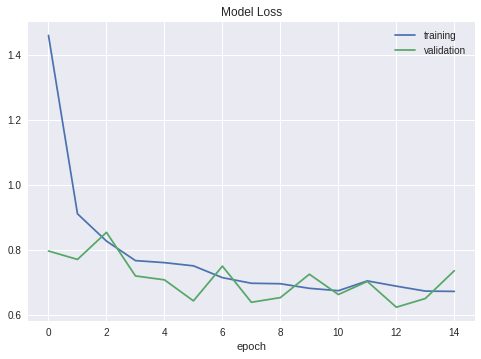

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

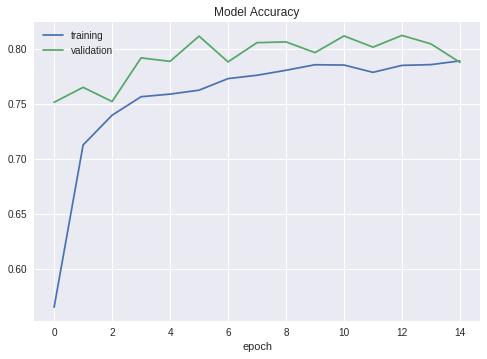

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Model Accuracy')
plt.xlabel('epoch')

Evaluate the model

In [53]:
score = model.evaluate(X_test, y_test , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.832397869080659
The Accuracy score is:  0.7790973871828353
